In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML


import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = False
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

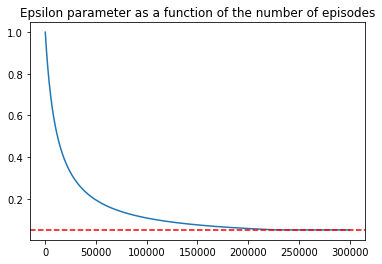

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 3*10**5
episodes_epsilon_min = 0.04*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  10**3
train_rew_freq =  10**2
train_Q_freq =  10**3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 13

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [8]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}") 

Exception: The simulation id you tried to use has been already used before. Try to change it to a new one.

In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
                rewards_list.append(discounted_reward);
                ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [16]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [ ]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9918 Discounted reward:  -8901289.927687936
Episode: 200. Elapsed time  0.14  minuts. epsilon 0.9837 Discounted reward:  -9148032.385910952
Episode: 300. Elapsed time  0.22  minuts. epsilon 0.9757 Discounted reward:  -7082668.175832177
Episode: 400. Elapsed time  0.32  minuts. epsilon 0.9678 Discounted reward:  -8532395.990062151
Episode: 500. Elapsed time  0.42  minuts. epsilon 0.9601 Discounted reward:  -9147128.461453011
Episode: 600. Elapsed time  0.53  minuts. epsilon 0.9525 Discounted reward:  -8441720.931244783
Episode: 700. Elapsed time  0.65  minuts. epsilon 0.945 Discounted reward:  -7563797.081142788
Episode: 800. Elapsed time  0.78  minuts. epsilon 0.9376 Discounted reward:  -7903966.399332017
Episode: 900. Elapsed time  0.92  minuts. epsilon 0.9303 Discounted reward:  -5755453.035199572
Episode: 1000. Elapsed time  1.06  minuts. epsilon 0.9231 Discounted reward:  -8904193.88683196
Episode: 1100. Elapsed time  1.21  minuts

Episode: 8600. Elapsed time  22.9  minuts. epsilon 0.5826 Discounted reward:  -3726848.7110588443
Episode: 8700. Elapsed time  23.28  minuts. epsilon 0.5797 Discounted reward:  -3657052.8839122257
Episode: 8800. Elapsed time  23.66  minuts. epsilon 0.577 Discounted reward:  -7592037.869474156
Episode: 8900. Elapsed time  24.05  minuts. epsilon 0.5742 Discounted reward:  -3330625.3564305007
Episode: 9000. Elapsed time  24.43  minuts. epsilon 0.5715 Discounted reward:  -7543139.600769714
Episode: 9100. Elapsed time  24.81  minuts. epsilon 0.5687 Discounted reward:  -6126467.257179653
Episode: 9200. Elapsed time  25.19  minuts. epsilon 0.5661 Discounted reward:  -5246412.697535374
Episode: 9300. Elapsed time  25.59  minuts. epsilon 0.5634 Discounted reward:  -5390504.385866934
Episode: 9400. Elapsed time  25.98  minuts. epsilon 0.5608 Discounted reward:  -5014853.196400621
Episode: 9500. Elapsed time  26.36  minuts. epsilon 0.5582 Discounted reward:  -5201995.707568962
Episode: 9600. Elap

Episode: 16900. Elapsed time  59.22  minuts. epsilon 0.4152 Discounted reward:  -2438010.3052083803
Episode: 17000. Elapsed time  59.69  minuts. epsilon 0.4138 Discounted reward:  -4811772.606094939
Episode: 17100. Elapsed time  60.19  minuts. epsilon 0.4124 Discounted reward:  -5462426.576126911
Episode: 17200. Elapsed time  60.67  minuts. epsilon 0.411 Discounted reward:  -4167315.818431869
Episode: 17300. Elapsed time  61.16  minuts. epsilon 0.4096 Discounted reward:  -2739459.142144351
Episode: 17400. Elapsed time  61.65  minuts. epsilon 0.4082 Discounted reward:  -3644412.9107232546
Episode: 17500. Elapsed time  62.13  minuts. epsilon 0.4068 Discounted reward:  -3389585.351243375
Episode: 17600. Elapsed time  62.62  minuts. epsilon 0.4054 Discounted reward:  -1753440.1473915512
Episode: 17700. Elapsed time  63.11  minuts. epsilon 0.4041 Discounted reward:  -5935508.497947078
Episode: 17800. Elapsed time  63.6  minuts. epsilon 0.4027 Discounted reward:  -2315735.7305930103
Episode:

Episode: 25200. Elapsed time  101.45  minuts. epsilon 0.3226 Discounted reward:  -2058187.904467274
Episode: 25300. Elapsed time  101.99  minuts. epsilon 0.3217 Discounted reward:  -1544925.062180241
Episode: 25400. Elapsed time  102.52  minuts. epsilon 0.3209 Discounted reward:  -2682946.3210515785
Episode: 25500. Elapsed time  103.06  minuts. epsilon 0.32 Discounted reward:  -1752925.2187520165
Episode: 25600. Elapsed time  103.59  minuts. epsilon 0.3192 Discounted reward:  -5455729.245779925
Episode: 25700. Elapsed time  104.12  minuts. epsilon 0.3183 Discounted reward:  -2596562.446727979
Episode: 25800. Elapsed time  104.66  minuts. epsilon 0.3175 Discounted reward:  -3269637.745526336
Episode: 25900. Elapsed time  105.2  minuts. epsilon 0.3166 Discounted reward:  -2789499.573691713
Episode: 26000. Elapsed time  105.73  minuts. epsilon 0.3158 Discounted reward:  -2477321.4813217754
Episode: 26100. Elapsed time  106.27  minuts. epsilon 0.315 Discounted reward:  -2112248.83671153
Ep

Episode: 33400. Elapsed time  146.69  minuts. epsilon 0.2643 Discounted reward:  -1565702.7056209613
Episode: 33500. Elapsed time  147.27  minuts. epsilon 0.2637 Discounted reward:  -3044843.5947437547
Episode: 33600. Elapsed time  147.85  minuts. epsilon 0.2632 Discounted reward:  -2874840.788128418
Episode: 33700. Elapsed time  148.43  minuts. epsilon 0.2626 Discounted reward:  -2490719.225280259
Episode: 33800. Elapsed time  149.01  minuts. epsilon 0.262 Discounted reward:  -1677742.6124689437
Episode: 33900. Elapsed time  149.58  minuts. epsilon 0.2614 Discounted reward:  -548907.5896091771
Episode: 34000. Elapsed time  150.16  minuts. epsilon 0.2609 Discounted reward:  -3730906.651767332
Episode: 34100. Elapsed time  150.72  minuts. epsilon 0.2603 Discounted reward:  -2357895.3648132905
Episode: 34200. Elapsed time  151.3  minuts. epsilon 0.2597 Discounted reward:  -1314070.3949966612
Episode: 34300. Elapsed time  151.89  minuts. epsilon 0.2592 Discounted reward:  -800790.52462030

Episode: 41600. Elapsed time  194.89  minuts. epsilon 0.2239 Discounted reward:  -2048489.998519641
Episode: 41700. Elapsed time  195.49  minuts. epsilon 0.2235 Discounted reward:  -4435495.363337798
Episode: 41800. Elapsed time  196.09  minuts. epsilon 0.2231 Discounted reward:  -3171740.214593509
Episode: 41900. Elapsed time  196.7  minuts. epsilon 0.2226 Discounted reward:  -1699662.3575385637
Episode: 42000. Elapsed time  197.29  minuts. epsilon 0.2222 Discounted reward:  -1618818.4759790874
Episode: 42100. Elapsed time  197.89  minuts. epsilon 0.2218 Discounted reward:  -1692171.0617756306
Episode: 42200. Elapsed time  198.49  minuts. epsilon 0.2214 Discounted reward:  -3604568.337878381
Episode: 42300. Elapsed time  199.08  minuts. epsilon 0.221 Discounted reward:  -420468.2454774745
Episode: 42400. Elapsed time  199.69  minuts. epsilon 0.2206 Discounted reward:  -1598957.4644153004
Episode: 42500. Elapsed time  200.29  minuts. epsilon 0.2202 Discounted reward:  -2871432.09612023

Episode: 49800. Elapsed time  244.12  minuts. epsilon 0.1942 Discounted reward:  -2517357.7273711427
Episode: 49900. Elapsed time  244.72  minuts. epsilon 0.1939 Discounted reward:  -3095099.997852606
Episode: 50000. Elapsed time  245.33  minuts. epsilon 0.1936 Discounted reward:  -1180981.3446785794
Episode: 50100. Elapsed time  245.94  minuts. epsilon 0.1932 Discounted reward:  -3970779.3656755127
Episode: 50200. Elapsed time  246.54  minuts. epsilon 0.1929 Discounted reward:  -1800000.9690355598
Episode: 50300. Elapsed time  247.15  minuts. epsilon 0.1926 Discounted reward:  -4056482.248969454
Episode: 50400. Elapsed time  247.75  minuts. epsilon 0.1923 Discounted reward:  -1984818.6846833238
Episode: 50500. Elapsed time  248.36  minuts. epsilon 0.192 Discounted reward:  -1528795.4850085159
Episode: 50600. Elapsed time  248.97  minuts. epsilon 0.1917 Discounted reward:  -1463070.5758687418
Episode: 50700. Elapsed time  249.58  minuts. epsilon 0.1914 Discounted reward:  -2163995.0343

Episode: 58000. Elapsed time  294.62  minuts. epsilon 0.1714 Discounted reward:  -1893203.7553714064
Episode: 58100. Elapsed time  295.25  minuts. epsilon 0.1712 Discounted reward:  -1330467.2090984073
Episode: 58200. Elapsed time  295.86  minuts. epsilon 0.1709 Discounted reward:  -3083178.1191529073
Episode: 58300. Elapsed time  296.49  minuts. epsilon 0.1707 Discounted reward:  -205891.78647680327
Episode: 58400. Elapsed time  297.1  minuts. epsilon 0.1705 Discounted reward:  -1712186.8717944138
Episode: 58500. Elapsed time  297.72  minuts. epsilon 0.1702 Discounted reward:  -1365330.861749762
Episode: 58600. Elapsed time  298.37  minuts. epsilon 0.17 Discounted reward:  -2253502.8563766647
Episode: 58700. Elapsed time  298.99  minuts. epsilon 0.1697 Discounted reward:  -1466299.8047911448
Episode: 58800. Elapsed time  299.61  minuts. epsilon 0.1695 Discounted reward:  -938506.2747505958
Episode: 58900. Elapsed time  300.23  minuts. epsilon 0.1693 Discounted reward:  -1896567.215891

Episode: 66200. Elapsed time  346.27  minuts. epsilon 0.1535 Discounted reward:  -1252663.9293632554
Episode: 66300. Elapsed time  346.91  minuts. epsilon 0.1533 Discounted reward:  -463198.4520149335
Episode: 66400. Elapsed time  347.54  minuts. epsilon 0.1531 Discounted reward:  -333544.2863314665
Episode: 66500. Elapsed time  348.18  minuts. epsilon 0.1529 Discounted reward:  -499114.3054445834
Episode: 66600. Elapsed time  348.82  minuts. epsilon 0.1527 Discounted reward:  0.002887884945498434
Episode: 66700. Elapsed time  349.46  minuts. epsilon 0.1525 Discounted reward:  -1048557.5151953724
Episode: 66800. Elapsed time  350.09  minuts. epsilon 0.1523 Discounted reward:  -1001599.5909379601
Episode: 66900. Elapsed time  350.73  minuts. epsilon 0.1521 Discounted reward:  -781334.8132839869
Episode: 67000. Elapsed time  351.36  minuts. epsilon 0.1519 Discounted reward:  -3263809.5418686843
Episode: 67100. Elapsed time  352.0  minuts. epsilon 0.1517 Discounted reward:  -1122233.41990

Episode: 74400. Elapsed time  398.76  minuts. epsilon 0.1389 Discounted reward:  -531260.9725762653
Episode: 74500. Elapsed time  399.4  minuts. epsilon 0.1387 Discounted reward:  -933433.1607608458
Episode: 74600. Elapsed time  400.04  minuts. epsilon 0.1386 Discounted reward:  -787150.4637865559
Episode: 74700. Elapsed time  400.68  minuts. epsilon 0.1384 Discounted reward:  -653017.7778753288
Episode: 74800. Elapsed time  401.32  minuts. epsilon 0.1383 Discounted reward:  -1921576.7730469587
Episode: 74900. Elapsed time  401.96  minuts. epsilon 0.1381 Discounted reward:  -519096.8130454541
Episode: 75000. Elapsed time  402.61  minuts. epsilon 0.1379 Discounted reward:  -313810.5950122638
Episode: 75100. Elapsed time  403.24  minuts. epsilon 0.1378 Discounted reward:  -687610.4853785024
Episode: 75200. Elapsed time  403.88  minuts. epsilon 0.1376 Discounted reward:  -268953.29176127515
Episode: 75300. Elapsed time  404.51  minuts. epsilon 0.1375 Discounted reward:  -919084.2076695269

Episode: 82600. Elapsed time  451.95  minuts. epsilon 0.1269 Discounted reward:  -1786773.8311766207
Episode: 82700. Elapsed time  452.61  minuts. epsilon 0.1267 Discounted reward:  -627621.6689112257
Episode: 82800. Elapsed time  453.26  minuts. epsilon 0.1266 Discounted reward:  -1334659.3728912063
Episode: 82900. Elapsed time  453.92  minuts. epsilon 0.1265 Discounted reward:  -430467.3425836429
Episode: 83000. Elapsed time  454.56  minuts. epsilon 0.1263 Discounted reward:  -720964.7447575768
Episode: 83100. Elapsed time  455.22  minuts. epsilon 0.1262 Discounted reward:  -3157999.0779576786
Episode: 83200. Elapsed time  455.87  minuts. epsilon 0.1261 Discounted reward:  -1341441.0062918998
Episode: 83300. Elapsed time  456.52  minuts. epsilon 0.1259 Discounted reward:  -805543.2988373566
Episode: 83400. Elapsed time  457.17  minuts. epsilon 0.1258 Discounted reward:  -3317179.9384662374
Episode: 83500. Elapsed time  457.82  minuts. epsilon 0.1257 Discounted reward:  -606850.440080

Episode: 90800. Elapsed time  505.6  minuts. epsilon 0.1167 Discounted reward:  -327245.01228636346
Episode: 90900. Elapsed time  506.26  minuts. epsilon 0.1166 Discounted reward:  -1167279.4442675512
Episode: 91000. Elapsed time  506.92  minuts. epsilon 0.1165 Discounted reward:  -165992.8001655226
Episode: 91100. Elapsed time  507.58  minuts. epsilon 0.1164 Discounted reward:  -317397.96161819075
Episode: 91200. Elapsed time  508.24  minuts. epsilon 0.1163 Discounted reward:  -1446879.7058788063
Episode: 91300. Elapsed time  508.89  minuts. epsilon 0.1162 Discounted reward:  -2336073.157598159
Episode: 91400. Elapsed time  509.54  minuts. epsilon 0.1161 Discounted reward:  -663599.7469232734
Episode: 91500. Elapsed time  510.2  minuts. epsilon 0.1159 Discounted reward:  -1965992.3712493556
Episode: 91600. Elapsed time  510.85  minuts. epsilon 0.1158 Discounted reward:  -0.091377172154679
Episode: 91700. Elapsed time  511.49  minuts. epsilon 0.1157 Discounted reward:  0.00140357006534

Episode: 99000. Elapsed time  559.45  minuts. epsilon 0.1081 Discounted reward:  -811842.4510131341
Episode: 99100. Elapsed time  560.12  minuts. epsilon 0.108 Discounted reward:  -1232163.7583127988
Episode: 99200. Elapsed time  560.79  minuts. epsilon 0.1079 Discounted reward:  -3121199.169279601
Episode: 99300. Elapsed time  561.45  minuts. epsilon 0.1078 Discounted reward:  -1264496.1286142648
Episode: 99400. Elapsed time  562.11  minuts. epsilon 0.1077 Discounted reward:  0.0025072668032365647
Episode: 99500. Elapsed time  562.77  minuts. epsilon 0.1076 Discounted reward:  -790633.7473509852
Episode: 99600. Elapsed time  563.43  minuts. epsilon 0.1075 Discounted reward:  -979954.0483125024
Episode: 99700. Elapsed time  564.1  minuts. epsilon 0.1074 Discounted reward:  -564859.095807771
Episode: 99800. Elapsed time  564.76  minuts. epsilon 0.1073 Discounted reward:  -1522612.3093847604
Episode: 99900. Elapsed time  565.42  minuts. epsilon 0.1072 Discounted reward:  -1232088.1189838

Episode: 107100. Elapsed time  613.63  minuts. epsilon 0.1008 Discounted reward:  -1064187.4953608962
Episode: 107200. Elapsed time  614.3  minuts. epsilon 0.1007 Discounted reward:  -834251.0868265321
Episode: 107300. Elapsed time  614.97  minuts. epsilon 0.1006 Discounted reward:  -794320.3039691536
Episode: 107400. Elapsed time  615.63  minuts. epsilon 0.1005 Discounted reward:  -1278639.7419123997
Episode: 107500. Elapsed time  616.3  minuts. epsilon 0.1004 Discounted reward:  -1632484.022165452
Episode: 107600. Elapsed time  616.97  minuts. epsilon 0.1003 Discounted reward:  -47102.08041893992
Episode: 107700. Elapsed time  617.64  minuts. epsilon 0.1003 Discounted reward:  -71789.79605880527
Episode: 107800. Elapsed time  618.31  minuts. epsilon 0.1002 Discounted reward:  -736099.5904408091
Episode: 107900. Elapsed time  618.98  minuts. epsilon 0.1001 Discounted reward:  -210206.34092303237
Episode: 108000. Elapsed time  619.65  minuts. epsilon 0.1 Discounted reward:  -2236324.58

Episode: 115200. Elapsed time  667.83  minuts. epsilon 0.0943 Discounted reward:  -627621.1895276473
Episode: 115300. Elapsed time  668.49  minuts. epsilon 0.0943 Discounted reward:  -1807982.850092692
Episode: 115400. Elapsed time  669.16  minuts. epsilon 0.0942 Discounted reward:  -590490.0219003062
Episode: 115500. Elapsed time  669.83  minuts. epsilon 0.0941 Discounted reward:  -1197421.540833024
Episode: 115600. Elapsed time  670.49  minuts. epsilon 0.094 Discounted reward:  -1482405.2078090326
Episode: 115700. Elapsed time  671.16  minuts. epsilon 0.094 Discounted reward:  -938840.3750737763
Episode: 115800. Elapsed time  671.83  minuts. epsilon 0.0939 Discounted reward:  0.002631370276732122
Episode: 115900. Elapsed time  672.5  minuts. epsilon 0.0938 Discounted reward:  -880119.4389789922
Episode: 116000. Elapsed time  673.15  minuts. epsilon 0.0938 Discounted reward:  -0.05523062579911727
Episode: 116100. Elapsed time  673.82  minuts. epsilon 0.0937 Discounted reward:  -166771

Episode: 123300. Elapsed time  722.27  minuts. epsilon 0.0887 Discounted reward:  -195914.5296249476
Episode: 123400. Elapsed time  722.94  minuts. epsilon 0.0886 Discounted reward:  0.0017394204740964624
Episode: 123500. Elapsed time  723.62  minuts. epsilon 0.0886 Discounted reward:  -1176066.9941683358
Episode: 123600. Elapsed time  724.3  minuts. epsilon 0.0885 Discounted reward:  -2000000.2801725229
Episode: 123700. Elapsed time  724.97  minuts. epsilon 0.0884 Discounted reward:  -2828594.404003038
Episode: 123800. Elapsed time  725.65  minuts. epsilon 0.0884 Discounted reward:  -395541.08693918906
Episode: 123900. Elapsed time  726.33  minuts. epsilon 0.0883 Discounted reward:  -1084778.102077781
Episode: 124000. Elapsed time  727.01  minuts. epsilon 0.0882 Discounted reward:  -0.19561242401279824
Episode: 124100. Elapsed time  727.69  minuts. epsilon 0.0882 Discounted reward:  -0.11883378964376094
Episode: 124200. Elapsed time  728.37  minuts. epsilon 0.0881 Discounted reward:  

Episode: 131400. Elapsed time  776.99  minuts. epsilon 0.0837 Discounted reward:  -218837.974933824
Episode: 131500. Elapsed time  777.66  minuts. epsilon 0.0836 Discounted reward:  -1092429.6716844374
Episode: 131600. Elapsed time  778.33  minuts. epsilon 0.0836 Discounted reward:  -578542.3014994931
Episode: 131700. Elapsed time  779.0  minuts. epsilon 0.0835 Discounted reward:  -536617.3932271336
Episode: 131800. Elapsed time  779.67  minuts. epsilon 0.0834 Discounted reward:  -294618.0556568672
Episode: 131900. Elapsed time  780.35  minuts. epsilon 0.0834 Discounted reward:  -434521.7755199625
Episode: 132000. Elapsed time  781.02  minuts. epsilon 0.0833 Discounted reward:  -751118.4151613584
Episode: 132100. Elapsed time  781.7  minuts. epsilon 0.0833 Discounted reward:  -150094.92523060084
Episode: 132200. Elapsed time  782.38  minuts. epsilon 0.0832 Discounted reward:  -542908.1478891097
Episode: 132300. Elapsed time  783.06  minuts. epsilon 0.0832 Discounted reward:  -590490.00

Episode: 139500. Elapsed time  832.37  minuts. epsilon 0.0792 Discounted reward:  -801943.9572147251
Episode: 139600. Elapsed time  833.07  minuts. epsilon 0.0792 Discounted reward:  0.002268655537897185
Episode: 139700. Elapsed time  833.75  minuts. epsilon 0.0791 Discounted reward:  -135085.1676667979
Episode: 139800. Elapsed time  834.44  minuts. epsilon 0.0791 Discounted reward:  -71789.79602864671
Episode: 139900. Elapsed time  835.13  minuts. epsilon 0.079 Discounted reward:  -919418.9898028917
Episode: 140000. Elapsed time  835.82  minuts. epsilon 0.0789 Discounted reward:  -0.0008560538345466736
Episode: 140100. Elapsed time  836.51  minuts. epsilon 0.0789 Discounted reward:  -627621.5044755854
Episode: 140200. Elapsed time  837.2  minuts. epsilon 0.0788 Discounted reward:  -109418.98733806843
Episode: 140300. Elapsed time  837.88  minuts. epsilon 0.0788 Discounted reward:  -592374.2076014865
Episode: 140400. Elapsed time  838.56  minuts. epsilon 0.0787 Discounted reward:  -304

Episode: 147600. Elapsed time  888.41  minuts. epsilon 0.0752 Discounted reward:  -774841.3500743461
Episode: 147700. Elapsed time  889.16  minuts. epsilon 0.0751 Discounted reward:  -308534.64558603533
Episode: 147800. Elapsed time  889.92  minuts. epsilon 0.0751 Discounted reward:  -602865.0228271526
Episode: 147900. Elapsed time  890.63  minuts. epsilon 0.075 Discounted reward:  -805765.0604657106
Episode: 148000. Elapsed time  891.32  minuts. epsilon 0.075 Discounted reward:  -243153.53788335822
Episode: 148100. Elapsed time  892.02  minuts. epsilon 0.075 Discounted reward:  -193366.70469757094
Episode: 148200. Elapsed time  892.72  minuts. epsilon 0.0749 Discounted reward:  -253977.59453605546
Episode: 148300. Elapsed time  893.42  minuts. epsilon 0.0749 Discounted reward:  -177258.97774810498
Episode: 148400. Elapsed time  894.11  minuts. epsilon 0.0748 Discounted reward:  -150094.89480813453
Episode: 148500. Elapsed time  911.01  minuts. epsilon 0.0748 Discounted reward:  -72900

Episode: 155700. Elapsed time  952.33  minuts. epsilon 0.0716 Discounted reward:  0.0027707471877351734
Episode: 155800. Elapsed time  952.9  minuts. epsilon 0.0715 Discounted reward:  -2180980.5276956307
Episode: 155900. Elapsed time  953.5  minuts. epsilon 0.0715 Discounted reward:  -300189.2701295585
Episode: 156000. Elapsed time  954.07  minuts. epsilon 0.0714 Discounted reward:  0.000839152878710518
Episode: 156100. Elapsed time  954.63  minuts. epsilon 0.0714 Discounted reward:  -1180980.661441215
Episode: 156200. Elapsed time  955.26  minuts. epsilon 0.0713 Discounted reward:  -47101.7046328466
Episode: 156300. Elapsed time  955.85  minuts. epsilon 0.0713 Discounted reward:  -47101.28428890432
Episode: 156400. Elapsed time  956.41  minuts. epsilon 0.0713 Discounted reward:  -863470.3594319357
Episode: 156500. Elapsed time  956.98  minuts. epsilon 0.0712 Discounted reward:  -254186.5801587549
Episode: 156600. Elapsed time  957.57  minuts. epsilon 0.0712 Discounted reward:  -90992

Episode: 163800. Elapsed time  1000.51  minuts. epsilon 0.0683 Discounted reward:  0.0020270275660062417
Episode: 163900. Elapsed time  1001.14  minuts. epsilon 0.0682 Discounted reward:  -637595.2590104433
Episode: 164000. Elapsed time  1001.74  minuts. epsilon 0.0682 Discounted reward:  -47101.28622645707
Episode: 164100. Elapsed time  1002.34  minuts. epsilon 0.0681 Discounted reward:  -1134671.796491061
Episode: 164200. Elapsed time  1002.94  minuts. epsilon 0.0681 Discounted reward:  -64610.81573390192
Episode: 164300. Elapsed time  1003.54  minuts. epsilon 0.0681 Discounted reward:  -899999.9956223249
Episode: 164400. Elapsed time  1004.15  minuts. epsilon 0.068 Discounted reward:  -71789.90632265098
Episode: 164500. Elapsed time  1004.76  minuts. epsilon 0.068 Discounted reward:  -1415311.661526923
Episode: 164600. Elapsed time  1005.38  minuts. epsilon 0.068 Discounted reward:  -1185302.2010068311
Episode: 164700. Elapsed time  1006.05  minuts. epsilon 0.0679 Discounted reward:

Episode: 171800. Elapsed time  1048.65  minuts. epsilon 0.0653 Discounted reward:  0.003127973709229358
Episode: 171900. Elapsed time  1049.2  minuts. epsilon 0.0653 Discounted reward:  0.0021639950384442995
Episode: 172000. Elapsed time  1049.77  minuts. epsilon 0.0652 Discounted reward:  -1302557.7740574582
Episode: 172100. Elapsed time  1050.33  minuts. epsilon 0.0652 Discounted reward:  -1852279.9484502356
Episode: 172200. Elapsed time  1050.89  minuts. epsilon 0.0651 Discounted reward:  -697357.2262650426
Episode: 172300. Elapsed time  1051.46  minuts. epsilon 0.0651 Discounted reward:  -64611.26792138455
Episode: 172400. Elapsed time  1052.02  minuts. epsilon 0.0651 Discounted reward:  -961908.2159847723
Episode: 172500. Elapsed time  1052.64  minuts. epsilon 0.065 Discounted reward:  -1062882.0189725019
Episode: 172600. Elapsed time  1053.31  minuts. epsilon 0.065 Discounted reward:  -489950.06527400966
Episode: 172700. Elapsed time  1053.89  minuts. epsilon 0.065 Discounted rew

Episode: 179800. Elapsed time  1096.8  minuts. epsilon 0.0626 Discounted reward:  -726098.2862833941
Episode: 179900. Elapsed time  1097.38  minuts. epsilon 0.0625 Discounted reward:  -293674.38282128
Episode: 180000. Elapsed time  1098.01  minuts. epsilon 0.0625 Discounted reward:  -0.20305273057136958
Episode: 180100. Elapsed time  1098.59  minuts. epsilon 0.0625 Discounted reward:  -956594.227539728
Episode: 180200. Elapsed time  1099.18  minuts. epsilon 0.0624 Discounted reward:  0.003449027414989379
Episode: 180300. Elapsed time  1099.81  minuts. epsilon 0.0624 Discounted reward:  -411782.4681036651
Episode: 180400. Elapsed time  1100.37  minuts. epsilon 0.0624 Discounted reward:  -1171811.4339438085
Episode: 180500. Elapsed time  1100.93  minuts. epsilon 0.0623 Discounted reward:  -2456693.244774944
Episode: 180600. Elapsed time  1101.58  minuts. epsilon 0.0623 Discounted reward:  -2111976.679619698
Episode: 180700. Elapsed time  1102.17  minuts. epsilon 0.0623 Discounted reward:

Episode: 187800. Elapsed time  1145.5  minuts. epsilon 0.0601 Discounted reward:  -1128768.14928346
Episode: 187900. Elapsed time  1146.1  minuts. epsilon 0.06 Discounted reward:  0.0023504361544305595
Episode: 188000. Elapsed time  1146.71  minuts. epsilon 0.06 Discounted reward:  -0.26336326735966176
Episode: 188100. Elapsed time  1147.34  minuts. epsilon 0.06 Discounted reward:  -1311782.2649866806
Episode: 188200. Elapsed time  1147.96  minuts. epsilon 0.0599 Discounted reward:  -88629.37875116468
Episode: 188300. Elapsed time  1148.53  minuts. epsilon 0.0599 Discounted reward:  -0.12091543724913406
Episode: 188400. Elapsed time  1149.12  minuts. epsilon 0.0599 Discounted reward:  -333543.74201612937
Episode: 188500. Elapsed time  1149.75  minuts. epsilon 0.0599 Discounted reward:  -345713.60324991087
Episode: 188600. Elapsed time  1150.42  minuts. epsilon 0.0598 Discounted reward:  -411782.3725449462
Episode: 188700. Elapsed time  1151.11  minuts. epsilon 0.0598 Discounted reward:

Episode: 195800. Elapsed time  1193.08  minuts. epsilon 0.0577 Discounted reward:  -430467.2106893299
Episode: 195900. Elapsed time  1193.72  minuts. epsilon 0.0577 Discounted reward:  -282429.5383658214
Episode: 196000. Elapsed time  1194.39  minuts. epsilon 0.0577 Discounted reward:  -52334.75994619068
Episode: 196100. Elapsed time  1195.01  minuts. epsilon 0.0577 Discounted reward:  -1427518.4242843692
Episode: 196200. Elapsed time  1195.64  minuts. epsilon 0.0576 Discounted reward:  -0.3494228856932823
Episode: 196300. Elapsed time  1196.25  minuts. epsilon 0.0576 Discounted reward:  -846631.124214023
Episode: 196400. Elapsed time  1196.79  minuts. epsilon 0.0576 Discounted reward:  -900000.0128833976
Episode: 196500. Elapsed time  1197.42  minuts. epsilon 0.0576 Discounted reward:  -934892.8885745303
Episode: 196600. Elapsed time  1198.07  minuts. epsilon 0.0575 Discounted reward:  -150094.7799914525
Episode: 196700. Elapsed time  1198.62  minuts. epsilon 0.0575 Discounted reward:

Episode: 203800. Elapsed time  1240.78  minuts. epsilon 0.0556 Discounted reward:  -1872882.2514069127
Episode: 203900. Elapsed time  1241.39  minuts. epsilon 0.0556 Discounted reward:  -197196.3213979813
Episode: 204000. Elapsed time  1241.91  minuts. epsilon 0.0556 Discounted reward:  -0.4281589988904708
Episode: 204100. Elapsed time  1242.45  minuts. epsilon 0.0555 Discounted reward:  -283071.2887264889
Episode: 204200. Elapsed time  1242.97  minuts. epsilon 0.0555 Discounted reward:  -590489.9996657438
Episode: 204300. Elapsed time  1243.6  minuts. epsilon 0.0555 Discounted reward:  -378421.478324357
Episode: 204400. Elapsed time  1244.17  minuts. epsilon 0.0555 Discounted reward:  -185302.08771817226
Episode: 204500. Elapsed time  1244.77  minuts. epsilon 0.0554 Discounted reward:  -801611.5726165363
Episode: 204600. Elapsed time  1245.33  minuts. epsilon 0.0554 Discounted reward:  -761813.3856935679
Episode: 204700. Elapsed time  1245.88  minuts. epsilon 0.0554 Discounted reward:

Episode: 211800. Elapsed time  1288.94  minuts. epsilon 0.0536 Discounted reward:  -3177640.1400388703
Episode: 211900. Elapsed time  1289.56  minuts. epsilon 0.0536 Discounted reward:  0.001500282668505199
Episode: 212000. Elapsed time  1290.18  minuts. epsilon 0.0536 Discounted reward:  -116299.57056687407
Episode: 212100. Elapsed time  1290.8  minuts. epsilon 0.0535 Discounted reward:  -1568400.486308535
Episode: 212200. Elapsed time  1291.42  minuts. epsilon 0.0535 Discounted reward:  -1068788.2247213272
Episode: 212300. Elapsed time  1292.05  minuts. epsilon 0.0535 Discounted reward:  -1795154.5044020207
Episode: 212400. Elapsed time  1292.67  minuts. epsilon 0.0535 Discounted reward:  -590490.164638786
Episode: 212500. Elapsed time  1293.35  minuts. epsilon 0.0535 Discounted reward:  -1176722.4193678326
Episode: 212600. Elapsed time  1293.96  minuts. epsilon 0.0534 Discounted reward:  -1774841.3631861014
Episode: 212700. Elapsed time  1294.61  minuts. epsilon 0.0534 Discounted re

Episode: 219800. Elapsed time  1337.95  minuts. epsilon 0.0518 Discounted reward:  -430467.207352334
Episode: 219900. Elapsed time  1338.62  minuts. epsilon 0.0517 Discounted reward:  0.0031752154230523027
Episode: 220000. Elapsed time  1339.37  minuts. epsilon 0.0517 Discounted reward:  -1529789.797944693
Episode: 220100. Elapsed time  1340.05  minuts. epsilon 0.0517 Discounted reward:  -205891.4460496369
Episode: 220200. Elapsed time  1340.71  minuts. epsilon 0.0517 Discounted reward:  -79766.440118685
Episode: 220300. Elapsed time  1341.43  minuts. epsilon 0.0517 Discounted reward:  -1670935.2261859078
Episode: 220400. Elapsed time  1342.17  minuts. epsilon 0.0516 Discounted reward:  -0.09532125741005255
Episode: 220500. Elapsed time  1342.85  minuts. epsilon 0.0516 Discounted reward:  -109419.1534680841
Episode: 220600. Elapsed time  1343.5  minuts. epsilon 0.0516 Discounted reward:  -1617552.1316164907
Episode: 220700. Elapsed time  1344.14  minuts. epsilon 0.0516 Discounted rewar

Episode: 227800. Elapsed time  1387.65  minuts. epsilon 0.05 Discounted reward:  -508373.16523703287
Episode: 227900. Elapsed time  1388.27  minuts. epsilon 0.05 Discounted reward:  -1000001.6969945037
Episode: 228000. Elapsed time  1388.92  minuts. epsilon 0.05 Discounted reward:  -430467.6380158936
Episode: 228100. Elapsed time  1389.54  minuts. epsilon 0.05 Discounted reward:  -787445.0825932472
Episode: 228200. Elapsed time  1390.16  minuts. epsilon 0.05 Discounted reward:  -198048.36770513508
Episode: 228300. Elapsed time  1390.79  minuts. epsilon 0.05 Discounted reward:  -151770.85844357358
Episode: 228400. Elapsed time  1391.41  minuts. epsilon 0.05 Discounted reward:  -656100.1335864161
Episode: 228500. Elapsed time  1392.04  minuts. epsilon 0.05 Discounted reward:  -656100.1483265305
Episode: 228600. Elapsed time  1392.64  minuts. epsilon 0.05 Discounted reward:  -58149.73496398731
Episode: 228700. Elapsed time  1393.35  minuts. epsilon 0.05 Discounted reward:  -0.077399787019

### Testing

In [13]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
episodes = 243000

tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 10
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []

In [14]:
def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq,
           test_verbose = test_verbose
           
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0      
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, reward, " Random action is performed. Current state unknown for Q.")

            else:
                reward = system.deterministic_action(best_action)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,reward, best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);


Test episode: 10

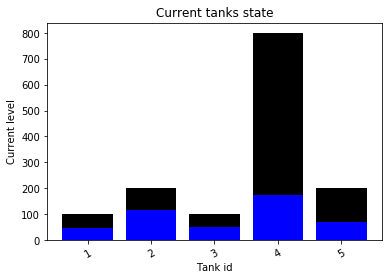

In [17]:
test_Q()
#print(np.mean(test_rewards_list) )

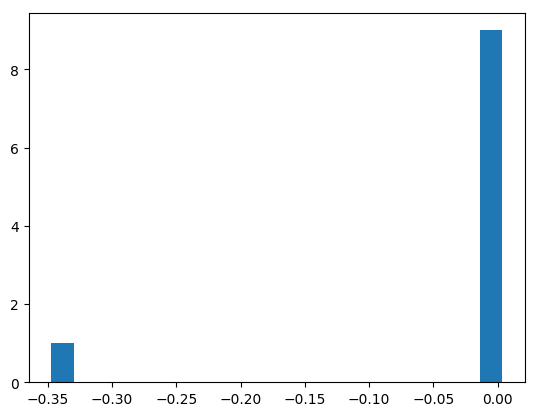

In [18]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

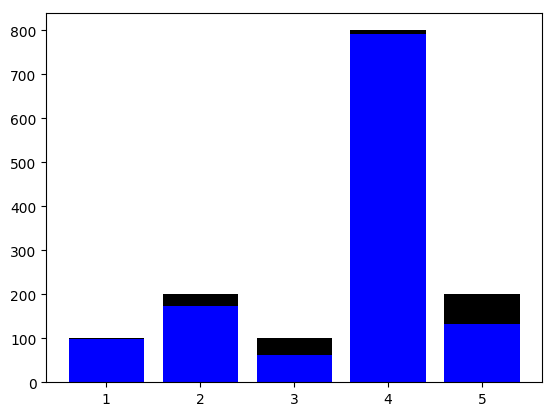

In [19]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


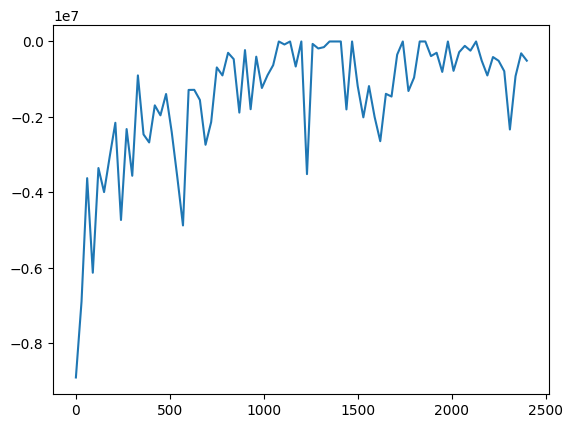

In [20]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
             discrewards_list2)

#plt.show()
plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

In [21]:
len(list(Q))

31427

In [24]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

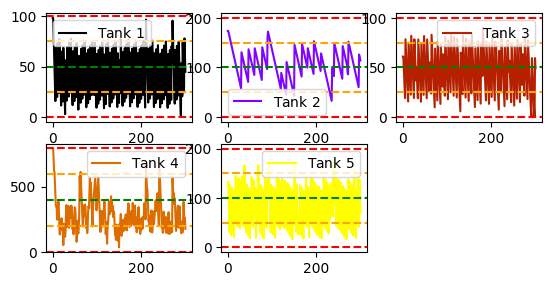

In [25]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

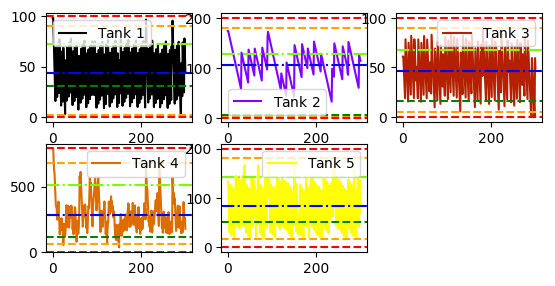

In [26]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')

In [ ]:
Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9579 Discounted reward:  -28000041.108963497
Episode: 200. Elapsed time  0.11  minuts. epsilon 0.9187 Discounted reward:  -26000043.136069976
Episode: 300. Elapsed time  0.18  minuts. epsilon 0.8827 Discounted reward:  -20000040.21466474
Episode: 400. Elapsed time  0.27  minuts. epsilon 0.8494 Discounted reward:  -25000023.10632617
Episode: 500. Elapsed time  0.37  minuts. epsilon 0.8185 Discounted reward:  -24000028.114429202
Episode: 600. Elapsed time  0.5  minuts. epsilon 0.7898 Discounted reward:  -26000033.119467866
Episode: 700. Elapsed time  0.63  minuts. epsilon 0.763 Discounted reward:  -24000030.426938158
Episode: 800. Elapsed time  0.76  minuts. epsilon 0.7379 Discounted reward:  -22000037.105293885
Episode: 900. Elapsed time  0.88  minuts. epsilon 0.7145 Discounted reward:  -16000027.214738708
Episode: 1000. Elapsed time  1.01  minuts. epsilon 0.6925 Discounted reward:  -13000021.99472654
Episode: 1100. Elapsed time  1.16  minuts. epsilon 0.6718 Discounted reward:  -15000024.008988662
Episode: 1200. Elapsed time  1.31  minuts. epsilon 0.6524 Discounted reward:  -18000029.226717632
Episode: 1300. Elapsed time  1.47  minuts. epsilon 0.634 Discounted reward:  -19000028.52769577
Episode: 1400. Elapsed time  1.63  minuts. epsilon 0.6166 Discounted reward:  -22000036.44480863
Episode: 1500. Elapsed time  1.8  minuts. epsilon 0.6002 Discounted reward:  -12000018.0040637
Episode: 1600. Elapsed time  1.98  minuts. epsilon 0.5846 Discounted reward:  -16000031.228442688
Episode: 1700. Elapsed time  2.16  minuts. epsilon 0.5698 Discounted reward:  -23000051.112380963
Episode: 1800. Elapsed time  2.37  minuts. epsilon 0.5557 Discounted reward:  -13000020.038069973
Episode: 1900. Elapsed time  2.63  minuts. epsilon 0.5423 Discounted reward:  -21000021.34935867
Episode: 2000. Elapsed time  2.84  minuts. epsilon 0.5295 Discounted reward:  -12000014.993348014
Episode: 2100. Elapsed time  3.04  minuts. epsilon 0.5174 Discounted reward:  -13000017.050656565
Episode: 2200. Elapsed time  3.24  minuts. epsilon 0.5057 Discounted reward:  -18000029.338394843
Episode: 2300. Elapsed time  3.45  minuts. epsilon 0.4946 Discounted reward:  -9000007.996369414
Episode: 2400. Elapsed time  3.65  minuts. epsilon 0.484 Discounted reward:  -20000028.995834745
Episode: 2500. Elapsed time  3.87  minuts. epsilon 0.4738 Discounted reward:  -12000008.99960373
Episode: 2600. Elapsed time  4.09  minuts. epsilon 0.464 Discounted reward:  -8000001.990621154
Episode: 2700. Elapsed time  4.32  minuts. epsilon 0.4546 Discounted reward:  -15000022.313438928
Episode: 2800. Elapsed time  4.55  minuts. epsilon 0.4456 Discounted reward:  -11000011.050444487
Episode: 2900. Elapsed time  4.79  minuts. epsilon 0.437 Discounted reward:  -7000012.998633672
Episode: 3000. Elapsed time  5.02  minuts. epsilon 0.4287 Discounted reward:  -8000005.264682835
Episode: 3100. Elapsed time  5.27  minuts. epsilon 0.4206 Discounted reward:  -11000018.992927592
Episode: 3200. Elapsed time  5.5  minuts. epsilon 0.4129 Discounted reward:  -7000009.997351216
Episode: 3300. Elapsed time  5.77  minuts. epsilon 0.4055 Discounted reward:  -13000011.030119121
Episode: 3400. Elapsed time  6.0  minuts. epsilon 0.3983 Discounted reward:  -18000023.3058256
Episode: 3500. Elapsed time  6.24  minuts. epsilon 0.3914 Discounted reward:  -7000002.996427942
Episode: 3600. Elapsed time  6.49  minuts. epsilon 0.3847 Discounted reward:  -11000007.309740528
Episode: 3700. Elapsed time  6.75  minuts. epsilon 0.3782 Discounted reward:  -11000012.001738582
Episode: 3800. Elapsed time  7.01  minuts. epsilon 0.372 Discounted reward:  -8000003.996528433
Episode: 3900. Elapsed time  7.31  minuts. epsilon 0.3659 Discounted reward:  -9000012.050633566
Episode: 4000. Elapsed time  7.58  minuts. epsilon 0.3601 Discounted reward:  -6000005.9967362685
Episode: 4100. Elapsed time  7.85  minuts. epsilon 0.3544 Discounted reward:  -7000008.991066201
Episode: 4200. Elapsed time  8.11  minuts. epsilon 0.3489 Discounted reward:  -8000002.004340031
Episode: 4300. Elapsed time  8.39  minuts. epsilon 0.3436 Discounted reward:  -6000007.205459152
Episode: 4400. Elapsed time  8.66  minuts. epsilon 0.3384 Discounted reward:  -7000008.088827883
Episode: 4500. Elapsed time  8.92  minuts. epsilon 0.3334 Discounted reward:  -10000008.016246885
Episode: 4600. Elapsed time  9.21  minuts. epsilon 0.3285 Discounted reward:  -5000008.212606534
Episode: 4700. Elapsed time  9.51  minuts. epsilon 0.3238 Discounted reward:  -8000007.021665757
Episode: 4800. Elapsed time  9.79  minuts. epsilon 0.3192 Discounted reward:  -8000008.038475299
Episode: 4900. Elapsed time  10.07  minuts. epsilon 0.3147 Discounted reward:  -18000020.03056307
Episode: 5000. Elapsed time  10.39  minuts. epsilon 0.3104 Discounted reward:  -10000006.999470046
Episode: 5100. Elapsed time  10.76  minuts. epsilon 0.3062 Discounted reward:  -7000004.998659743
Episode: 5200. Elapsed time  11.05  minuts. epsilon 0.3021 Discounted reward:  -7000007.06712629
Episode: 5300. Elapsed time  11.38  minuts. epsilon 0.2981 Discounted reward:  -8000009.999546508
Episode: 5400. Elapsed time  11.69  minuts. epsilon 0.2942 Discounted reward:  -5000000.995678231
Episode: 5500. Elapsed time  11.99  minuts. epsilon 0.2904 Discounted reward:  -4000003.9933600356
Episode: 5600. Elapsed time  12.29  minuts. epsilon 0.2867 Discounted reward:  -11000004.996177264
Episode: 5700. Elapsed time  12.59  minuts. epsilon 0.2831 Discounted reward:  -6000003.999741462
Episode: 5800. Elapsed time  12.9  minuts. epsilon 0.2795 Discounted reward:  -2000006.9925141241
Episode: 5900. Elapsed time  13.2  minuts. epsilon 0.2761 Discounted reward:  -8000007.987305785
Episode: 6000. Elapsed time  13.54  minuts. epsilon 0.2728 Discounted reward:  -4000000.993550161